In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.markers import MarkerStyle
from matplotlib.transforms import Affine2D
from matplotlib.ticker import MultipleLocator, MaxNLocator
from matplotlib.lines import Line2D

import seaborn as sns
from ast import literal_eval
from pathlib import Path
from itertools import product
import warnings
import os

warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set(font_scale=1.5,rc={'text.usetex' : True})
sns.set_style("whitegrid")
plt.rc('font', **{'family': 'serif'})
plt.rcParams["figure.figsize"] = (12, 3)

In [2]:
dataset_names = {37:"Diabetes",
                 61:"Iris",
                 40975: "Car",
                 42900: "Breast Cancer Coimbra",
                 41945: "Indian Liver Patients",
                 187:"Wine",
                 "segmentation": "Customer Segmentation",
                 "player":"Football Player"}

label_mapping={"lookahead":"Lookahead",
            "method":"Method",
            "score_set": "Score Set",
            "calibration_method": "Calibration",
            "('calibration_method', 'isotonic')":"Isotonic Regression",
            "beta":"Beta Calibration",
            "psl_prebin":"PSL",
            "msl_prebin":"MSL",
            "stage":"Stage",
            "train_ent":"Expected Entropy",
            "clf_variant": "Variant",
            "bisect":"Bisect",
            "brute":"Bruteforce",
            "test_brier" : "Brier Score",
            "test_roc" : "ROC AUC",
            "train_roc" : "ROC AUC",
            "soft_ranking_loss": "Soft Rank Loss",
            "expected_entropy":"Expected Entropy",
            "'psl_prebin_logreg'" : "Logistic Regression",
            "msl_prebin_logreg" : "Logistic Regression",
            "msl_prebin_nb" : "Naive Bayes",
            "msl_prebin_miss": "MISS",
            "msl_prebin_xgboost": "XGBoost",
            "msl_prebin_random_forest": "Random Forest",
            "psl_prebin_logreg" : "Logistic Regression"
            }

hue_order=["psl_prebin","msl_prebin", "msl_prebin_nb","msl_prebin_miss", "msl_prebin_logreg","msl_prebin_random_forest","msl_prebin_xgboost"]

In [12]:
def load_results(folder, folds=None):
    df = pd.concat((pd.read_csv(f) for f in Path(folder).glob("*.csv") if f.stat().st_size > 0 ), ignore_index=True)
    df = df.drop("params",axis=1)
    df["test_brier"] = -df["test_brier"]
    df["train_brier"] = -df["train_brier"]
    df = df[df.fold<folds if folds is not None else np.inf]
    df["clf_variant"] = df.clf.str.cat(df.clf_variant, sep="_", na_rep="").str.rstrip("_")
    return df
df = load_results("results_90s_miss",20)
#df = load_results("results",20)
#df = load_results("result.bak",20)

In [13]:
df.clf_variant.unique()

array(['psl_prebin', 'msl_prebin', 'msl_prebin_nb', 'msl_prebin_logreg',
       'msl_prebin_xgboost', 'msl_prebin_random_forest',
       'msl_prebin_miss'], dtype=object)

In [14]:
df.columns

Index(['dataset', 'fold', 'clf', 'score_set', 'fit_time', 'score_time',
       'test_acc', 'train_acc', 'test_aaacc', 'train_aaacc', 'test_bacc',
       'train_bacc', 'test_ece', 'train_ece', 'test_roc', 'train_roc',
       'test_brier', 'train_brier', 'test_recall', 'train_recall',
       'test_recall_at_wloss', 'train_recall_at_wloss', 'test_prec',
       'train_prec', 'test_spec_at_wloss', 'train_spec_at_wloss', 'test_f1',
       'train_f1', 'test_ent', 'train_ent', 'test_cov', 'train_cov',
       'test_eff', 'train_eff', 'n_features', 'stage', 'clf_variant'],
      dtype='object')

In [15]:
df.dataset.unique()

array([42900, 61, 'player', 37, 41945, 187, 'segmentation'], dtype=object)

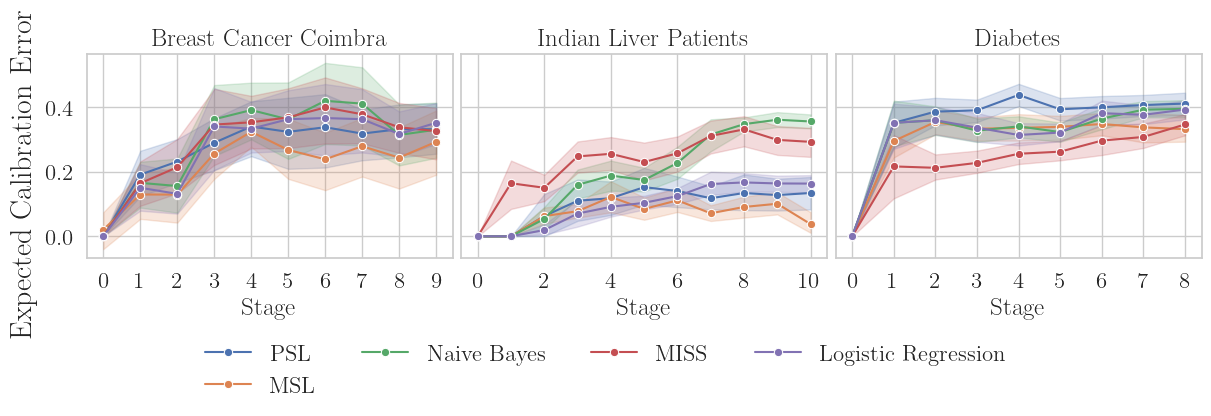

In [16]:
datasets = [42900, 41945,37]
fig,axes = plt.subplots(1,len(datasets), sharey=True, layout='constrained')
axes = axes.ravel()

metric= "bacc"

for index, dataset in enumerate(datasets):
    ax=axes[index]

    df_ = df[(df.dataset == datasets[index])
    & (df.clf_variant.isin([ "psl_prebin","msl_prebin", "msl_prebin_miss", "msl_prebin_nb", "msl_prebin_logreg"]))
    & (~df.stage.isnull())]
    hue_order_ = [clf_variant if clf_variant in set(df_.clf_variant.unique()) else None for  clf_variant in hue_order]
    sns.lineplot(data=df_, x="stage", y=f"test_{metric}", hue="clf_variant", marker="o", ax=ax, hue_order=hue_order_)    
    if index == 1:
        handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(None)
    ax.set_xlabel("Stage")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

syl = fig.supylabel("Expected Calibration Error")
labels = [label_mapping[label] for label in labels]

lgd = fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig(f"fig/binary_{metric}.pdf",bbox_extra_artists=(lgd,syl), bbox_inches='tight')

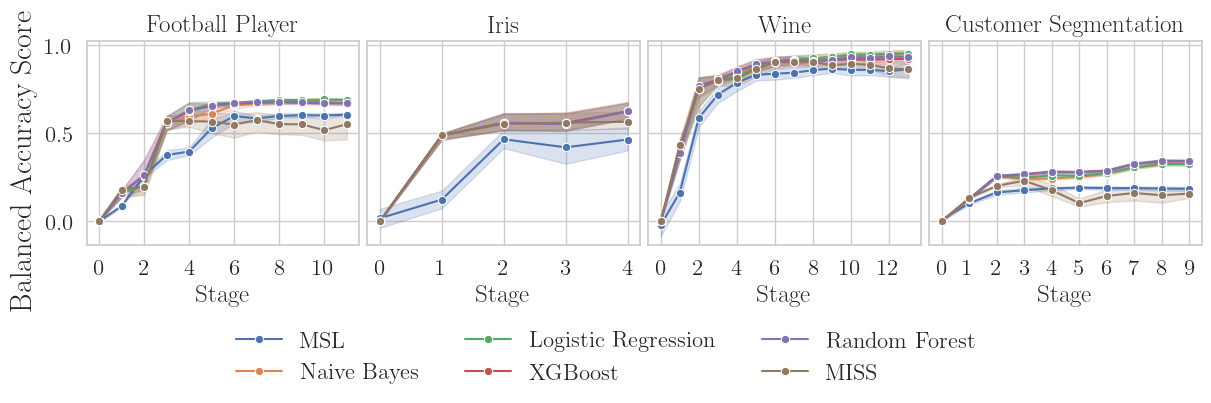

In [17]:
datasets = ["player",61,187,"segmentation"]
fig,axes = plt.subplots(1,len(datasets), sharey=True, layout='constrained')
axes = axes.ravel()

for index, dataset in enumerate(datasets):
    ax=axes[index]

    df_ = df[(df.dataset == datasets[index])
    & (df.clf_variant.isin(["msl_prebin", "msl_prebin_miss", "msl_prebin_logreg", "msl_prebin_nb", "msl_prebin_xgboost", "msl_prebin_random_forest"]))
    & (~df.stage.isnull())]
    sns.lineplot(data=df_, x="stage", y="test_bacc", hue="clf_variant", marker="o", ax=ax)    
    if index == 1:
        handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(None)
    ax.set_xlabel("Stage")
    #ax.set_xticks(list(range(0,11)))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

syl = fig.supylabel("Balanced Accuracy Score")
labels = [label_mapping[label] for label in labels]

lgd = fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig("fig/brier_2.pdf",bbox_extra_artists=(lgd,syl), bbox_inches='tight')

KeyError: 'MSL'

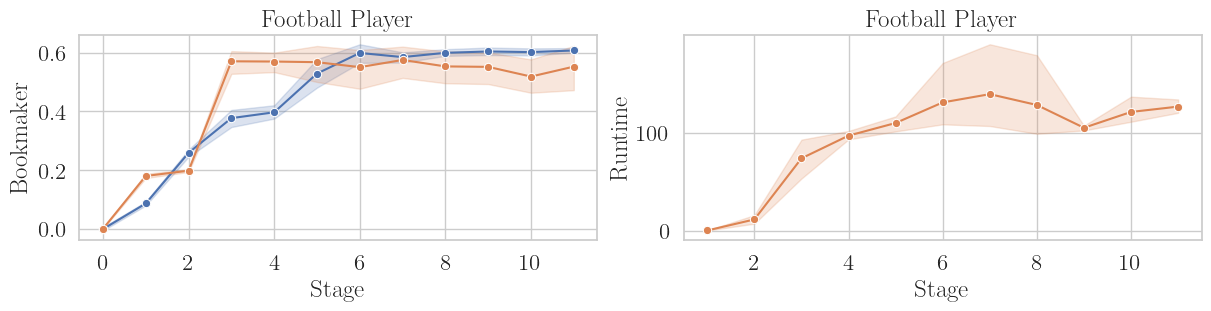

In [18]:
datasets = ["player"]
fig,axes = plt.subplots(1,len(datasets)+1, sharey=False, layout='constrained')
axes = axes.ravel()

ax = axes[0]

df_ = df[(df.dataset == datasets[0])
& (df.clf_variant.isin(["msl_prebin", "msl_prebin_miss"]))
& (~df.stage.isnull())]
sns.lineplot(data=df_, x="stage", y="test_bacc", hue="clf_variant", marker="o", ax=ax)    
if index == 1:
    handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove()
ax.set_title(dataset_names[datasets[0]])
ax.set_ylabel("Bookmaker")
ax.set_xlabel("Stage")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax = axes[1]

df_ = df[(df.dataset == datasets[0])
& (df.clf_variant.isin(["msl_prebin", "msl_prebin_miss"]))
& (~df.stage.isnull())]
sns.lineplot(data=df_, x="stage", y="fit_time", hue="clf_variant", marker="o", ax=ax) 
ax.get_legend().remove()
ax.set_title(dataset_names[datasets[0]])
ax.set_ylabel("Runtime")
ax.set_xlabel("Stage")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

labels = [label_mapping[label] for label in labels]

lgd = fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig("fig/brier_2.pdf",bbox_extra_artists=(lgd,syl), bbox_inches='tight')

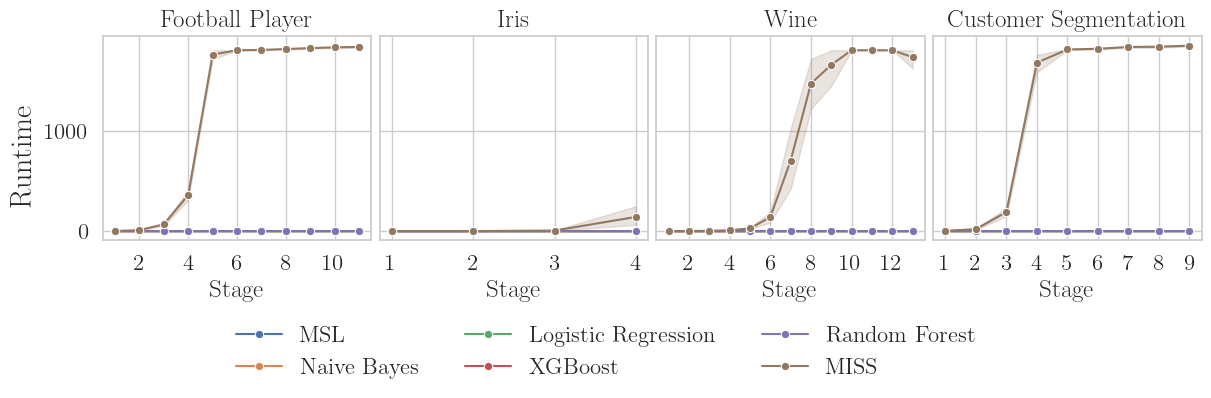

In [ ]:
datasets = ["player",61,187,"segmentation"]
fig,axes = plt.subplots(1,len(datasets), sharey=True, layout='constrained')
axes = axes.ravel()

for index, dataset in enumerate(datasets):
    ax=axes[index]

    df_ = df[(df.dataset == datasets[index])
    & (df.clf_variant.isin(["msl_prebin", "msl_prebin_miss", "msl_prebin_logreg", "msl_prebin_nb", "msl_prebin_xgboost", "msl_prebin_random_forest"]))
    & (~df.stage.isnull())]
    sns.lineplot(data=df_, x="stage", y="fit_time", hue="clf_variant", marker="o", ax=ax)    
    if index == 1:
        handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    ax.set_title(dataset_names[dataset])
    ax.set_ylabel(None)
    ax.set_xlabel("Stage")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

syl = fig.supylabel("Runtime")
labels = [label_mapping[label] for label in labels]

lgd = fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 0), frameon=False)
plt.savefig("fig/brier_2.pdf",bbox_extra_artists=(lgd,syl), bbox_inches='tight')

/tmp/ipykernel_1395438/172222176.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label_mapping[item.get_text()] for item in ax.get_xticklabels()])


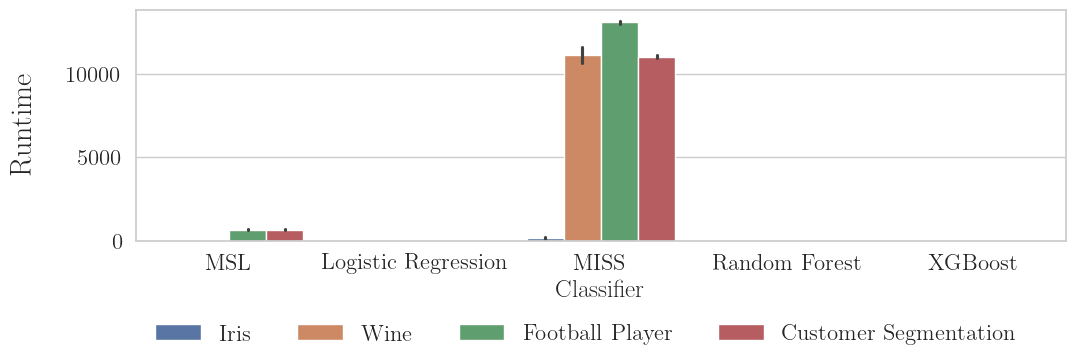

In [ ]:
fig,ax = plt.subplots(1)

df_ = df[(df.dataset.isin(["player",61,187,"segmentation"]))
& (df.clf_variant.isin(["msl_prebin", "msl_prebin_miss", "msl_prebin_logreg", "msl_prebin_nb", "msl_prebin_xgboost", "msl_prebin_random_forest"]))
].dropna(subset="fit_time").groupby(["dataset","fold","clf", "clf_variant"]).sum()
sns.barplot(data=df_, y="fit_time", x="clf_variant",hue="dataset", ax=ax)
ax.get_legend().remove()
ax.set_ylabel(None)
ax.set_xlabel("Classifier")
ax.set_xticklabels([label_mapping[item.get_text()] for item in ax.get_xticklabels()])

syl = fig.supylabel("Runtime")
handles, labels = ax.get_legend_handles_labels()
labels = [dataset_names[int(label) if label.isdigit() else label] for label in labels]
lgd = fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.1), frameon=False)